In [1]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from datetime import datetime

In [2]:
buzz_df = pd.read_csv('file_for_dictionary/multiTimeline.csv')
buzz_df = buzz_df.iloc[1:,]
buzz_df.reset_index(inplace=True)
buzz_df.columns = ['date','buzz']
buzz_df['buzz'] = [int(i) for i in buzz_df['buzz']]
buzz_df.tail()

,date,buzz
47,2018-11-11,50
48,2018-11-18,58
49,2018-11-25,42
50,2018-12-02,43
51,2018-12-09,40


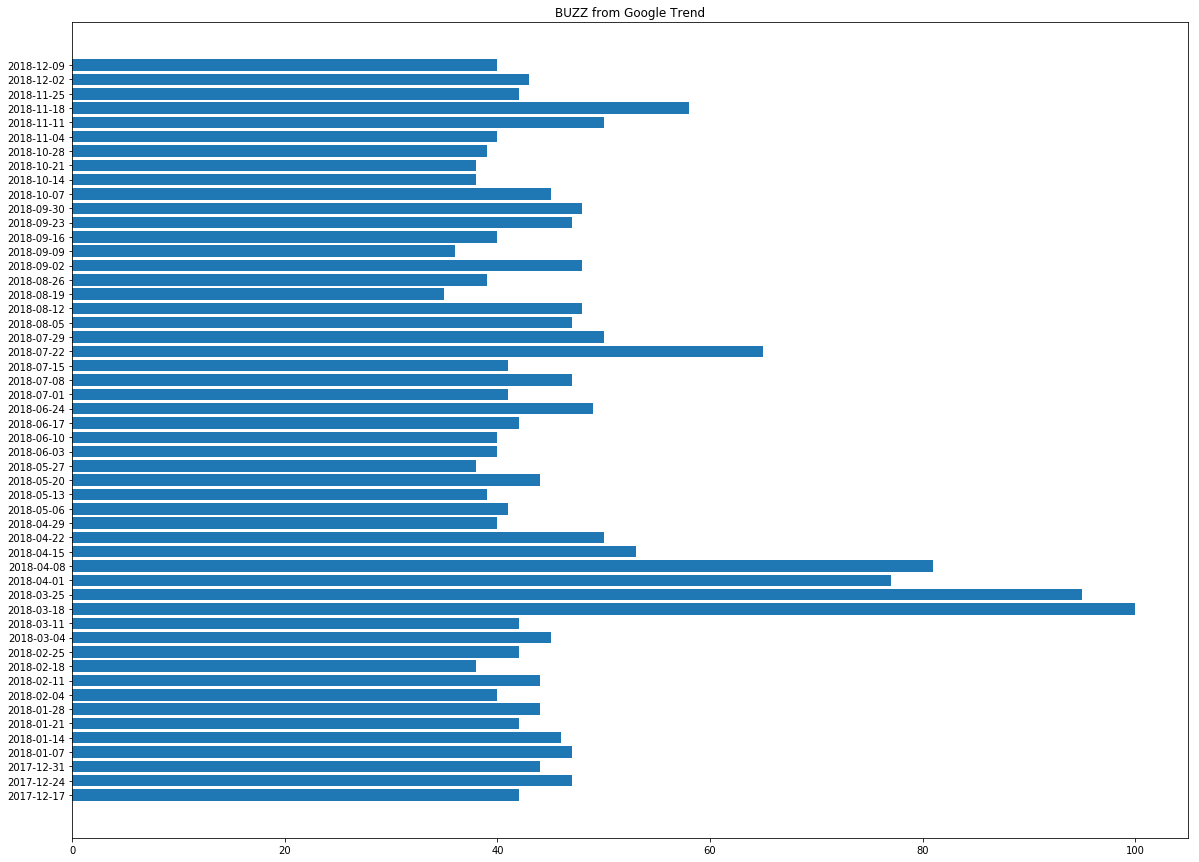

In [3]:
plt.figure(figsize=(20,15))
plt.title('BUZZ from Google Trend')
plt.barh(buzz_df['date'],buzz_df['buzz'])
plt.show()

In [4]:
buzz_df[buzz_df['buzz'] > np.quantile(buzz_df['buzz'],0.75)]

,date,buzz
13,2018-03-18,100
14,2018-03-25,95
15,2018-04-01,77
16,2018-04-08,81
17,2018-04-15,53
18,2018-04-22,50
27,2018-06-24,49
31,2018-07-22,65
32,2018-07-29,50
47,2018-11-11,50


In [5]:
from selenium import webdriver
import time

In [6]:
driver = webdriver.Chrome()
driver.get("https://www.google.com/search?q=facebook&biw=1855&bih=984&source=lnt&tbs=cdr%3A1%2Ccd_min%3A3%2F1%2F2018%2Ccd_max%3A3%2F31%2F2018&tbm=nws")
url_ls = []
date_ls = []

for page in range(10):
    time.sleep(1)
    for i in range(1,10+1):
        url_ls.append(driver.find_element_by_css_selector(\
        '#rso > div > div:nth-child({}) > div > div.gG0TJc > h3 > a'.format(i)).text)
        date_ls.append(driver.find_element_by_css_selector(\
'#rso > div > div:nth-child({}) > div > div.gG0TJc > div.slp > span.f.nsa.fwzPFf'.format(i)).text)
    driver.execute_script('window.scrollTo(100,10000)')
    driver.find_element_by_css_selector('#pnnext').click()
driver.close()

In [7]:
revised_date_ls = []

for idx in range(len(date_ls)) :
    date_split_ls = date_ls[idx].replace('.','').split(' ')
    year = date_split_ls[0]
    month = date_split_ls[1]
    day = date_split_ls[2]
    day = str(day) + ' ' + str(month) + ' ' + str(year)
    revised_date_ls.append(datetime.strptime(day, '%d %m %Y').date())
title_sent = dict(zip(revised_date_ls,url_ls))
sent_df = pd.DataFrame.from_dict(title_sent,orient='index').sort_index()
sent_df.rename(columns={0:'title'},inplace=True)

In [8]:
sent_df['title']

2018-03-01    T. Rowe Price's Page Says 'We're Entering a Pe...
2018-03-02    Newlyweds take hilarious wedding photos inside...
2018-03-05                  5 Growth Hacking Tips For Musicians
2018-03-06    Winnie the Pooh Reunites With an Old Friend in...
2018-03-07    Michelle Obama dances with Parker the portrait...
2018-03-08    Introducing a whole new way to enjoy Quartz, o...
2018-03-09    Doors to Interior Secretary Ryan Zinke's offic...
2018-03-13       UN: Facebook had a 'role' in Rohingya genocide
2018-03-14                    Facebook bans Britain First pages
2018-03-15    Juul e-cigarettes and teens: 'Health problem o...
2018-03-16    WhatsApp sharing user data with Facebook would...
2018-03-17    Chi è la fidanzata di Riki? Sara Gotti, l'affa...
2018-03-18                  Peter Rabbit review – unfunny bunny
2018-03-19         Convergys to lay off 300 in Jefferson County
2018-03-20    'Curvy' Instagrammer's inspiring message about...
2018-03-21    Viral Damascus 'Goat Monst

In [9]:
import personal_pkg as per
import pandas as pd
import numpy as np
from IPython.display import display , Markdown
import requests
from bs4 import BeautifulSoup
from scrapy.http import TextResponse
from datetime import datetime, timedelta
import nltk
import matplotlib.pylab as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import matplotlib
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import FinanceDataReader as fdr
from datetime import datetime

# 값 설정
plt.rcParams['figure.figsize'] = (14,4)
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

### Adjusting the methodology of scoring

stock_lex = pd.read_csv('file_for_dictionary/stock_lex.csv')
stock_lex['sentiment'] = (stock_lex['Aff_Score'] + stock_lex['Neg_Score'])/2
stock_lex = dict(zip(stock_lex.Item, stock_lex.sentiment))
stock_lex = {k:v for k,v in stock_lex.items() if len(k.split(' '))==1}

stock_lex_scaled = {}
for k, v in stock_lex.items():
    if v > 0:
        stock_lex_scaled[k] = v / max(stock_lex.values()) * 4
    else:
        stock_lex_scaled[k] = v / min(stock_lex.values()) * -4

display(pd.DataFrame(np.array(list(stock_lex_scaled.values()))).describe().loc[['min','max'],:])

# Loughran and McDonald
negative_ls = [i.strip() for i in per.convert_pdf_to_txt('file_for_dictionary/LM_Negative.pdf').split('\n')]
negative_ls = [i for i in negative_ls if i and 'Negative' not in i]

positive_ls = [i.strip() for i in per.convert_pdf_to_txt('file_for_dictionary/LM_Positive.pdf').split('\n')]
positive_ls = [i for i in positive_ls if i and 'Positive' not in i]

final_lex = {}
final_lex.update({word:2.0 for word in positive_ls})
final_lex.update({word:-2.0 for word in negative_ls})
final_lex.update(stock_lex_scaled)
final_lex.update(sia.lexicon)
sia.lexicon = final_lex

,0
min,-4.0
max,4.0


In [10]:
score_ls = []

for idx,val in enumerate(sent_df['title'].tolist()):
    score_ls.append(sia.polarity_scores(val)['compound'])
date_sentiment = dict(zip(revised_date_ls,score_ls))
earliest_date = min(revised_date_ls)

,score,1day_before,plus_or_minus
2018-03-01,0.2364,0.2364,0.02
2018-03-06,0.0872,0.2364,0.02
2018-03-09,0.3410,0.0872,0.03
2018-03-13,0.2115,0.3410,0.07
2018-03-14,0.4221,0.2115,0.09
2018-03-17,-0.0311,0.4221,-0.01
2018-03-19,0.2590,-0.0311,-0.01
2018-03-20,-0.3938,0.2590,-0.10
2018-03-21,-0.1622,-0.3938,0.06
2018-03-22,-0.0928,-0.1622,0.02


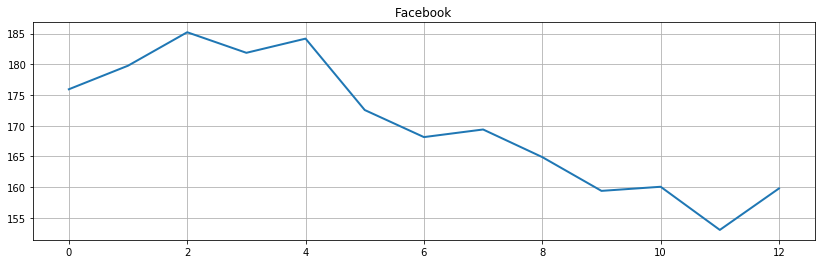

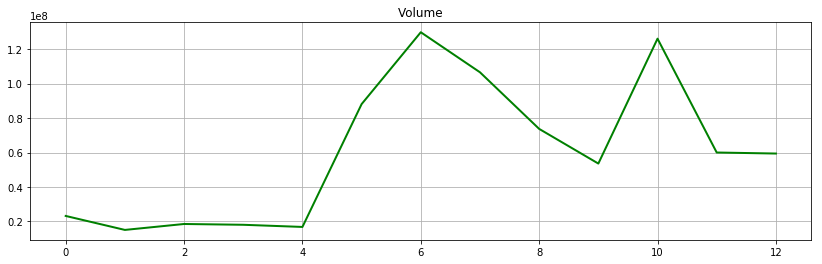

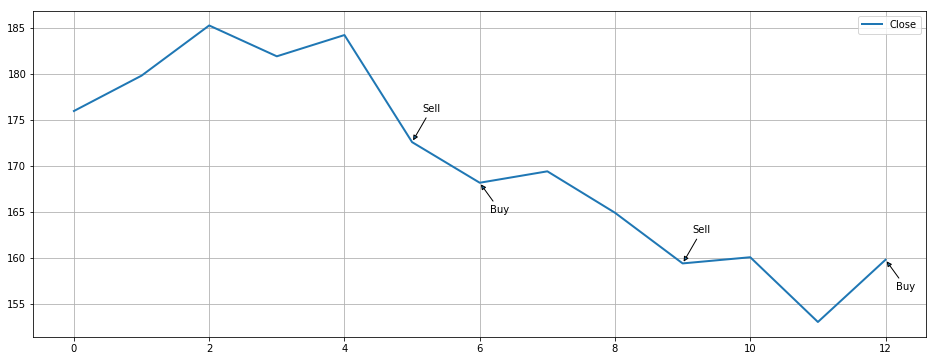

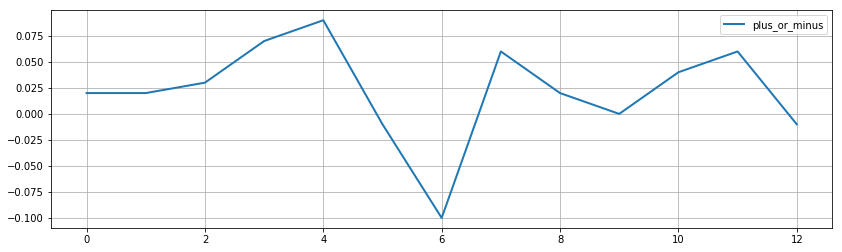

In [13]:
score_df = pd.DataFrame.from_dict(date_sentiment,orient='index')
score_df.rename(columns={0:'score'},inplace=True)
score_df.sort_index(inplace=True)
score_df['1day_before'] = score_df.shift(periods=1)['score'].tolist()
score_df['plus_or_minus'] = np.round(score_df['score'] * score_df['1day_before'],2)
score_df.fillna(method='bfill',inplace=True)
display(score_df)

signal_ls = []

for idx,val in enumerate(score_df['plus_or_minus'].tolist()) : 
    if val <= 0 : 
        if score_df['score'][idx] > score_df['1day_before'][idx] : 
            signal_ls.append('sell')
        else : 
            signal_ls.append('buy')
    else : signal_ls.append('0')

score_df['signal'] = signal_ls

score_df.reset_index(inplace=True)
score_df.rename(columns={'index':'Date'},inplace=True)

start = earliest_date
end = max(revised_date_ls)

# FaceBook
df = fdr.DataReader("FB", start, end)
df = df[['Close', 'Volume']]
df.reset_index(inplace=True)

revised_date_ls = []

for idx,val in enumerate(df['Date'].tolist()) :
    day = str(df['Date'][idx].day) + ' ' + str(df['Date'][idx].month) + ' ' + str(df['Date'][idx].year)
    revised_date_ls.append(datetime.strptime(day, '%d %m %Y').date())
df['Date'] = revised_date_ls

trade_df = pd.merge(score_df,df,on='Date')

ax = trade_df[['Close']].plot(figsize=(16,6))
for key, val in trade_df['signal'].iteritems():
    if val == 0:
        continue

    if val == 'buy' :
        ax.annotate('Buy', xy=(key, trade_df['Close'][key]), xytext=(10,-30), 
                    textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
    elif val == 'sell':
        ax.annotate('Sell', xy=(key, trade_df['Close'][key]), xytext=(10,30), 
                    textcoords='offset points', arrowprops=dict(arrowstyle='-|>'))
        

trade_df[['plus_or_minus']].plot()

In [14]:
testing_df = pd.DataFrame()
testing_df['return'] = trade_df['Close'].pct_change()
testing_df['return'] = [i+1 for i in testing_df['return']]
testing_df.fillna(1,inplace=True)
testing_df.head()

,return
0,1.000000
1,1.021826
2,1.030315
3,0.981914
4,1.012701


In [15]:
new_return_ls = []
for idx in range(len(trade_df)) : 
    if trade_df['signal'][idx] != '0' : 
        if trade_df['signal'][idx] == 'buy' : 
            new_return_ls.append(testing_df['return'][idx])
        else :
            new_return_ls.append( 2- testing_df['return'][idx])
    else : 
        new_return_ls.append(testing_df['return'][idx])
testing_df['new_return'] = new_return_ls

In [17]:
from functools import reduce

In [18]:
print(reduce(lambda x,y:x*y, testing_df['return'].tolist()))
print(reduce(lambda x,y:x*y, testing_df['new_return'].tolist()))

0.9082073434125268
1.101754810832749


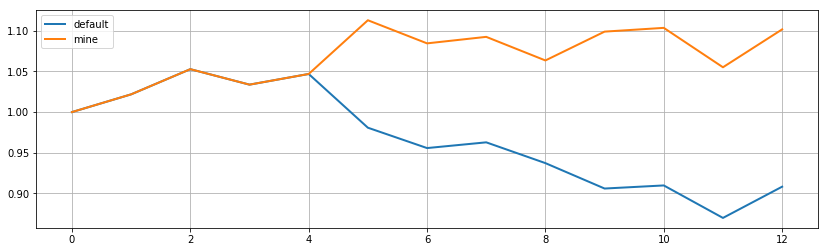

In [19]:
plt.plot(testing_df['return'].cumprod(),label='default')
plt.plot(testing_df['new_return'].cumprod(),label='mine')
plt.legend() ; plt.grid(True)